In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
from matplotlib import gridspec
from Bio import SeqIO
import h5py as h5
from scipy.stats import pearsonr, spearmanr
import vizsequence
import logomaker as lm
import bioframe
from multiprocessing import Pool
import warnings
warnings.filterwarnings('ignore')

### Selected variants:
- 5:138601629:A:G (chr10:13,982,000-13,993,200) - AP1 motif, allele-specific BATF binding
- 5:110716624:G:A (chr5:110,711,700-110,721,600) - ETS_1 motif, allele-specific SPI1 binding

- 13:75300385:GC:G, 13:75300388:T:C, 13:75300392:T:C - NFKB motif, TBC1D4 gene (NA12878, HG02601 and HG03464), RELA/RELB ChIP-seq
- 2:113235808:C:G - ETS motif, PAX8-AS1 gene (NA12878 and HG01241), ELF1 ChIP-seq
- 7:116498515:C:T - RUNX motif, CAV2 gene (NA12878 and HG03464), RUNX3 ChIP-seq
- 17:35244527:G:A - IRF motif, SLFN5 gene (NA18983, HG01241 and HG02601), IRF4 ChIP-seq
- 17:8901000:T:G - OCT motif, PIK3R5 gene (HG03464)

## Functions

In [2]:
def read_variants(sample):
    variants = pd.read_csv(f'/DATA/users/m.magnitov/hap_phen/personal_genomes/{sample}/{sample}.phased.het.bed', 
                           sep = '\t', header = None)
    variants[11] = [int(x.split('|')[0]) for x in variants[10].values]
    variants[12] = [int(x.split('|')[1].split(':')[0]) for x in variants[10].values]
    variants = variants[[0, 2, 2, 3, 5, 6, 11, 12]]
    variants.columns = ['chrom', 'start', 'end', 'variant_id', 'ref', 'alt', 'allele_ref', 'allele_alt']
    return(variants)

def read_variants_on_haplotype(sample, haplotype):
    with open(f'/DATA/users/m.magnitov/hap_phen/personal_genomes/{sample}/genome/{sample}_{haplotype}.vcf', 'r') as v_hap:
        variants_hap = v_hap.readlines()
    variants_hap = [x.rstrip('\n').split('\t') for x in variants_hap if x[0] != '#']
    variants_hap = pd.DataFrame(variants_hap)
    variants_hap = variants_hap[[0, 1, 1, 2]]
    variants_hap.columns = ['chrom', 'start_' + haplotype, 'end_' + haplotype, 'variant_id']
    return(variants_hap)

def read_asocr_peaks(sample):
    asocr_peaks = pd.read_csv(f'/DATA/users/m.magnitov/hap_phen/ATACseq/asocr/{sample}_allele_specific.bed', sep = '\t', header = None)
    asocr_peaks.columns = ['chrom', 'start', 'end', 'peak_id', 'baseMean', 'log2FoldChange', 'FDR']
    return(asocr_peaks[['chrom', 'start', 'end', 'peak_id', 'log2FoldChange', 'FDR']])

def read_balanced_peaks(sample):
    balanced_peaks = pd.read_csv(f'/DATA/users/m.magnitov/hap_phen/ATACseq/asocr/{sample}_balanced.bed', sep = '\t', header = None)
    balanced_peaks.columns = ['chrom', 'start', 'end', 'peak_id', 'baseMean', 'log2FoldChange', 'FDR']
    return(balanced_peaks[['chrom', 'start', 'end', 'peak_id', 'log2FoldChange', 'FDR']])

def get_variants_for_peaks(phased_variants, peaks):
    peaks = peaks[peaks['chrom'] != 'chrX']
    phased_variants_overlap_peaks = bioframe.overlap(phased_variants, peaks, suffixes = ('', '_peak'))
    phased_variants_overlap_peaks = phased_variants_overlap_peaks.dropna()

    putative_non_overlaps = peaks[~peaks['peak_id'].isin(phased_variants_overlap_peaks['peak_id_peak'])]['peak_id'].values
    if len(putative_non_overlaps) != 0:
        peaks_non_overlaps = peaks[peaks['peak_id'].isin(putative_non_overlaps)]

        phased_variants_overlap_non_overlaps = bioframe.closest(peaks_non_overlaps, phased_variants, suffixes = ('_peak', ''))
        sort_order = list(phased_variants_overlap_non_overlaps.columns[5:]) + list(phased_variants_overlap_non_overlaps.columns[:5])
        phased_variants_overlap_non_overlaps = phased_variants_overlap_non_overlaps[sort_order]
        phased_variants_overlap_non_overlaps = phased_variants_overlap_non_overlaps.drop('distance', axis = 1)

    phased_variants_overlap_peaks = pd.concat([phased_variants_overlap_peaks, phased_variants_overlap_non_overlaps], ignore_index = True)
    phased_variants_overlap_peaks = phased_variants_overlap_peaks.sort_values(['chrom', 'start'])
    phased_variants_overlap_peaks.index = np.arange(len(phased_variants_overlap_peaks))
    return(phased_variants_overlap_peaks)

In [3]:
def get_variant_coordinates_in_haplotypes(phased_variants_data, variant_id):
    chrom_name = phased_variants_data[phased_variants_data['variant_id'] == variant_id]['chrom'].values[0]
    pos_hap1 = int(phased_variants_data[phased_variants_data['variant_id'] == variant_id][f'start_hap1'].values[0])
    pos_hap2 = int(phased_variants_data[phased_variants_data['variant_id'] == variant_id][f'start_hap2'].values[0])
    return(chrom_name, pos_hap1, pos_hap2)

def extract_sequence_for_region(genome, chrom, pos, flank):
    return(str(genome[chrom][pos-flank-1:pos+flank]))

def extract_contribution_scores_for_region(contrib_scores, chrom, pos, flank):
    contrib_scores_per_region = contrib_scores[(contrib_scores['chrom'] == chrom) & (contrib_scores['start'] >= pos-flank-1) & (contrib_scores['end'] <= pos+flank)]
    if len(contrib_scores_per_region) != 2*flank+1:
        contrib_scores_per_region_extended = pd.DataFrame({'chrom': [chrom]*(2*flank+1),
                                                           'start': np.arange(pos-flank-1, pos+flank),
                                                           'end': np.arange(pos-flank, pos+flank+1)})
        contrib_scores_per_region_extended = contrib_scores_per_region_extended.merge(contrib_scores_per_region, 
                                                                                      on = ['chrom', 'start', 'end'], how = 'left').fillna(0)
        contrib_scores_per_region_extended['relative_pos'] = contrib_scores_per_region_extended['end']-pos
        return(contrib_scores_per_region_extended)
    else:
        contrib_scores_per_region['relative_pos'] = contrib_scores_per_region['end']-pos
        return(contrib_scores_per_region)

def construct_cs_matrix_to_plot(seq_contrib, score_contrib):
    contrib_score_data = pd.DataFrame([list(seq_contrib), score_contrib]).transpose().fillna(0)
    contrib_score_data.columns = ['character', 'value']
    contrib_score_data = lm.saliency_to_matrix(seq = contrib_score_data['character'], values = contrib_score_data['value'])
    return(contrib_score_data)

def contribution_data_to_matrix(variant_contrib_data):
    contrib_score_matrix_hap1, contrib_score_matrix_hap2 = [], []
    for i in range(len(variant_contrib_data)):
        if variant_contrib_data['seq_hap1'].values[i] == 'A':
            contrib_score_matrix_hap1.append([variant_contrib_data['score_hap1'].values[i], 0, 0, 0])
        elif variant_contrib_data['seq_hap1'].values[i] == 'C':
            contrib_score_matrix_hap1.append([0, variant_contrib_data['score_hap1'].values[i], 0, 0])
        elif variant_contrib_data['seq_hap1'].values[i] == 'G':
            contrib_score_matrix_hap1.append([0, 0, variant_contrib_data['score_hap1'].values[i], 0])
        if variant_contrib_data['seq_hap1'].values[i] == 'T':
            contrib_score_matrix_hap1.append([0, 0, 0, variant_contrib_data['score_hap1'].values[i]])

    for i in range(len(variant_contrib_data)):
        if variant_contrib_data['seq_hap2'].values[i] == 'A':
            contrib_score_matrix_hap2.append([variant_contrib_data['score_hap2'].values[i], 0, 0, 0])
        elif variant_contrib_data['seq_hap2'].values[i] == 'C':
            contrib_score_matrix_hap2.append([0, variant_contrib_data['score_hap2'].values[i], 0, 0])
        elif variant_contrib_data['seq_hap2'].values[i] == 'G':
            contrib_score_matrix_hap2.append([0, 0, variant_contrib_data['score_hap2'].values[i], 0])
        if variant_contrib_data['seq_hap2'].values[i] == 'T':
            contrib_score_matrix_hap2.append([0, 0, 0, variant_contrib_data['score_hap2'].values[i]])

    contrib_score_matrix_hap1 = pd.DataFrame(contrib_score_matrix_hap1)
    contrib_score_matrix_hap2 = pd.DataFrame(contrib_score_matrix_hap2)
    contrib_score_matrix_hap1.columns = ['A', 'C', 'G', 'T']
    contrib_score_matrix_hap2.columns = ['A', 'C', 'G', 'T']
    contrib_score_matrix_hap1['relative_pos'] = variant_contrib_data['relative_pos']
    contrib_score_matrix_hap2['relative_pos'] = variant_contrib_data['relative_pos']

    return(contrib_score_matrix_hap1, contrib_score_matrix_hap2)

def read_pwm(pwm_name):
    pwm = pd.read_csv(f'/DATA/users/m.magnitov/hap_phen/chromBPNet/variants_annotation/tf_modisco_pwms/{pwm_name}.pfm', 
                      header = None, skiprows = 1, sep = '\s+')
    pwm.index = [x.rstrip(':') for x in pwm[0].values]
    pwm = pwm.drop([0], axis = 1).T
    return(pwm)

def relative_info_content(pwm):
    p = pwm/np.sum(pwm, axis = 1)[:,np.newaxis]
    ic = 2+np.sum(p*np.nan_to_num(np.log2(p)), axis = 1)
    ric = p*ic[:,np.newaxis]
    return(ric)

# Plot contributions for variants

In [25]:
sample = 'NA12878'

In [26]:
# Read phased variants coordinates in hg38 and exclude chrX from analyses
phased_variants = read_variants(sample)
phased_variants = phased_variants[phased_variants['chrom'] != 'chrX']

# Read phased variants coordinates lifted to haplotype 1 and haplotype 2 coordinates
variants_hap1 = read_variants_on_haplotype(sample, 'hap1')
variants_hap2 = read_variants_on_haplotype(sample, 'hap2')

In [27]:
# Read allele-specific peaks
asocr_peaks = read_asocr_peaks(sample)

# Overlap phased variants with allele-specific peaks
phased_variants_overlap_asocr = get_variants_for_peaks(phased_variants, asocr_peaks)
phased_variants_overlap_asocr = phased_variants_overlap_asocr.merge(variants_hap1, on = ['chrom', 'variant_id'])
phased_variants_overlap_asocr = phased_variants_overlap_asocr.merge(variants_hap2, on = ['chrom', 'variant_id'])
phased_variants_overlap_asocr.head()

,chrom,start,end,variant_id,ref,alt,allele_ref,allele_alt,chrom_peak,start_peak,end_peak,peak_id_peak,log2FoldChange_peak,FDR_peak,start_hap1,end_hap1,start_hap2,end_hap2
0,chr1,828014,828014,1:828014:G:A,G,A,0,1,chr1,826832,828040,NA12878_peak_2,6.379673,0.000012,828014,828014,828017,828017
1,chr1,1038800,1038800,1:1038800:G:T,G,T,0,1,chr1,1038446,1039331,NA12878_peak_20,1.476120,0.000369,1038795,1038795,1038755,1038755
2,chr1,1038819,1038819,1:1038819:C:T,C,T,0,1,chr1,1038446,1039331,NA12878_peak_20,1.476120,0.000369,1038814,1038814,1038774,1038774
3,chr1,1038845,1038845,1:1038845:A:G,A,G,0,1,chr1,1038446,1039331,NA12878_peak_20,1.476120,0.000369,1038840,1038840,1038800,1038800
4,chr1,1038916,1038916,1:1038916:A:G,A,G,0,1,chr1,1038446,1039331,NA12878_peak_20,1.476120,0.000369,1038911,1038911,1038871,1038871


In [28]:
# Read balanced peaks
balanced_peaks = read_balanced_peaks(sample)

# Overlap phased variants with balanced peaks
phased_variants_overlap_balanced = get_variants_for_peaks(phased_variants, balanced_peaks)
phased_variants_overlap_balanced = phased_variants_overlap_balanced.merge(variants_hap1, on = ['chrom', 'variant_id'])
phased_variants_overlap_balanced = phased_variants_overlap_balanced.merge(variants_hap2, on = ['chrom', 'variant_id'])
phased_variants_overlap_balanced.head()

,chrom,start,end,variant_id,ref,alt,allele_ref,allele_alt,chrom_peak,start_peak,end_peak,peak_id_peak,log2FoldChange_peak,FDR_peak,start_hap1,end_hap1,start_hap2,end_hap2
0,chr1,984039,984039,1:984039:T:C,T,C,0,1,chr1,983992,984545,NA12878_peak_14,0.544771,0.801716,984025,984025,984016,984016
1,chr1,984109,984109,1:984109:C:T,C,T,0,1,chr1,983992,984545,NA12878_peak_14,0.544771,0.801716,984095,984095,984086,984086
2,chr1,984145,984145,1:984145:TAGTC:T,TAGTC,T,0,1,chr1,983992,984545,NA12878_peak_14,0.544771,0.801716,984131,984131,984122,984122
3,chr1,984475,984475,1:984475:G:A,G,A,1,0,chr1,983992,984545,NA12878_peak_14,0.544771,0.801716,984461,984461,984448,984448
4,chr1,999842,999842,1:999842:C:A,C,A,0,1,chr1,999622,1001164,NA12878_peak_15,0.773273,0.496534,999841,999841,999812,999812


In [29]:
# Read genomes for each haplotype
hap1_genome, hap2_genome = {}, {}
for record in SeqIO.parse(f'/DATA/users/m.magnitov/hap_phen/personal_genomes/{sample}/genome/{sample}_hap1.fa', 'fasta'):
    hap1_genome[record.id] = str(record.seq)
for record in SeqIO.parse(f'/DATA/users/m.magnitov/hap_phen/personal_genomes/{sample}/genome/{sample}_hap2.fa', 'fasta'):
    hap2_genome[record.id] = str(record.seq)

In [30]:
# Read contribution scores for each haplotype
contrib_scores_hap1 = pd.read_csv(f'/DATA/users/m.magnitov/hap_phen/chromBPNet/contrib/{sample}_hap1.profile_scores.bed', sep = '\t', header = None)
contrib_scores_hap2 = pd.read_csv(f'/DATA/users/m.magnitov/hap_phen/chromBPNet/contrib/{sample}_hap2.profile_scores.bed', sep = '\t', header = None)
contrib_scores_hap1.columns = ['chrom', 'start', 'end', 'score_hap1']
contrib_scores_hap2.columns = ['chrom', 'start', 'end', 'score_hap2']

## Plot allele-specific contributions

In [12]:
variant_id = '13:75300388:T:C'
gene_name = 'TBC1D4'

#variant_id = '2:113235808:C:G'
#gene_name = 'PAX8-AS1'

#variant_id = '7:116498515:C:T'
#gene_name = 'CAV2'

#variant_id = '17:35244527:G:A'
#gene_name = 'SLFN5'

#variant_id = '17:8901000:T:G'
#gene_name = 'PIK3R5'

variant_margin = max(len(variant_id.split(':')[2]), len(variant_id.split(':')[3]))-1
flank = 25 + variant_margin

chrom_name, variant_pos_hap1, variant_pos_hap2 = get_variant_coordinates_in_haplotypes(phased_variants_overlap_asocr, variant_id)
seq_hap1 = extract_sequence_for_region(hap1_genome, chrom_name, variant_pos_hap1, flank)
seq_hap2 = extract_sequence_for_region(hap2_genome, chrom_name, variant_pos_hap2, flank)
contrib_hap1 = extract_contribution_scores_for_region(contrib_scores_hap1, chrom_name, variant_pos_hap1, flank)
contrib_hap2 = extract_contribution_scores_for_region(contrib_scores_hap2, chrom_name, variant_pos_hap2, flank)

contrib = contrib_hap1.merge(contrib_hap2, on = ['chrom', 'relative_pos'], how = 'outer').sort_values('relative_pos').fillna(0)
seq = pd.DataFrame({'relative_pos': np.arange(-flank, flank+1), 'seq_hap1': list(seq_hap1), 'seq_hap2': list(seq_hap2)})

variant_contrib_data = contrib.merge(seq, on = 'relative_pos')
variant_contrib_data = variant_contrib_data[['relative_pos', 'score_hap1', 'score_hap2', 'seq_hap1', 'seq_hap2']]
variant_contrib_matrix_hap1, variant_contrib_matrix_hap2 = contribution_data_to_matrix(variant_contrib_data)

cm_hap1 = construct_cs_matrix_to_plot(''.join(list(variant_contrib_data['seq_hap1'])), variant_contrib_data['score_hap1'])
cm_hap2 = construct_cs_matrix_to_plot(''.join(list(variant_contrib_data['seq_hap2'])), variant_contrib_data['score_hap2'])
cm_plot_limit_min = np.min(np.min(variant_contrib_data[['score_hap1', 'score_hap2']]))
cm_plot_limit_max = np.max(np.max(variant_contrib_data[['score_hap1', 'score_hap2']]))
cm_plot_margin = (abs(cm_plot_limit_max)+abs(cm_plot_limit_min))*0.1

(-0.0011651524000000002, 0.0047543084)

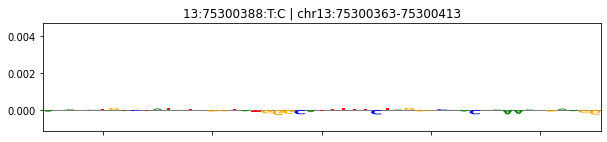

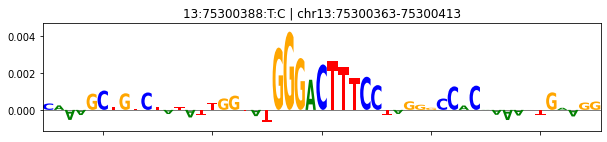

In [15]:
lm.Logo(cm_hap1, figsize = (10, 2))
plt.title(variant_id + ' | chr' + variant_id.split(':')[0] + ':' + str(int(variant_id.split(':')[1])-25) + '-' + str(int(variant_id.split(':')[1])+25))
plt.xticks([5, 15, 25, 35, 45], [])
plt.xlim(-0.5, 50.5)
plt.ylim((cm_plot_limit_min-cm_plot_margin, cm_plot_limit_max+cm_plot_margin))
#plt.savefig(f'/DATA/users/m.magnitov/hap_phen/chromBPNet/example_tracks/gene_{gene_name}_example_{sample}_hap1.png', bbox_inches = 'tight')
#plt.savefig(f'/DATA/users/m.magnitov/hap_phen/chromBPNet/example_tracks/gene_{gene_name}_example_{sample}_hap1.pdf', bbox_inches = 'tight')

lm.Logo(cm_hap2, figsize = (10, 2))
plt.title(variant_id + ' | chr' + variant_id.split(':')[0] + ':' + str(int(variant_id.split(':')[1])-25) + '-' + str(int(variant_id.split(':')[1])+25))
plt.xticks([5, 15, 25, 35, 45], [])
plt.xlim(-0.5, 50.5)
plt.ylim((cm_plot_limit_min-cm_plot_margin, cm_plot_limit_max+cm_plot_margin))
#plt.savefig(f'/DATA/users/m.magnitov/hap_phen/chromBPNet/example_tracks/gene_{gene_name}_example_{sample}_hap2.png', bbox_inches = 'tight')
#plt.savefig(f'/DATA/users/m.magnitov/hap_phen/chromBPNet/example_tracks/gene_{gene_name}_example_{sample}_hap2.pdf', bbox_inches = 'tight')

## Plot balanced contributions

In [31]:
#variant_id = '10:79347379:A:C'
#gene_name = 'PPIF_promoter'
# hap1 - C
# hap2 - A

variant_id = '1:243287831:G:A'
gene_name = 'SDCCAG8_enhancer'
# hap1 - A
# hap2 - G

variant_margin = max(len(variant_id.split(':')[2]), len(variant_id.split(':')[3]))-1
flank = 25 + variant_margin

chrom_name, variant_pos_hap1, variant_pos_hap2 = get_variant_coordinates_in_haplotypes(phased_variants_overlap_balanced, variant_id)
seq_hap1 = extract_sequence_for_region(hap1_genome, chrom_name, variant_pos_hap1, flank)
seq_hap2 = extract_sequence_for_region(hap2_genome, chrom_name, variant_pos_hap2, flank)
contrib_hap1 = extract_contribution_scores_for_region(contrib_scores_hap1, chrom_name, variant_pos_hap1, flank)
contrib_hap2 = extract_contribution_scores_for_region(contrib_scores_hap2, chrom_name, variant_pos_hap2, flank)

contrib = contrib_hap1.merge(contrib_hap2, on = ['chrom', 'relative_pos'], how = 'outer').sort_values('relative_pos').fillna(0)
seq = pd.DataFrame({'relative_pos': np.arange(-flank, flank+1), 'seq_hap1': list(seq_hap1), 'seq_hap2': list(seq_hap2)})

variant_contrib_data = contrib.merge(seq, on = 'relative_pos')
variant_contrib_data = variant_contrib_data[['relative_pos', 'score_hap1', 'score_hap2', 'seq_hap1', 'seq_hap2']]
variant_contrib_matrix_hap1, variant_contrib_matrix_hap2 = contribution_data_to_matrix(variant_contrib_data)

cm_hap1 = construct_cs_matrix_to_plot(''.join(list(variant_contrib_data['seq_hap1'])), variant_contrib_data['score_hap1'])
cm_hap2 = construct_cs_matrix_to_plot(''.join(list(variant_contrib_data['seq_hap2'])), variant_contrib_data['score_hap2'])
cm_plot_limit_min = np.min(np.min(variant_contrib_data[['score_hap1', 'score_hap2']]))
cm_plot_limit_max = np.max(np.max(variant_contrib_data[['score_hap1', 'score_hap2']]))
cm_plot_margin = (abs(cm_plot_limit_max)+abs(cm_plot_limit_min))*0.1

(-0.010389709, 0.014952119000000002)

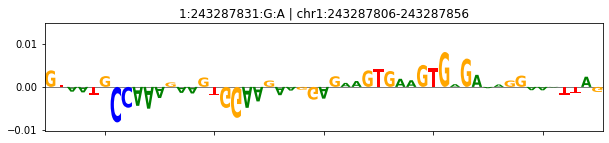

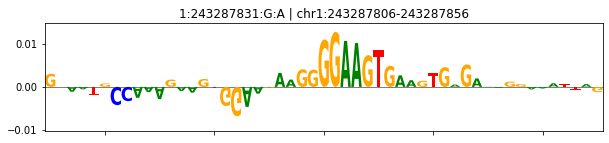

In [34]:
lm.Logo(cm_hap1, figsize = (10, 2))
plt.title(variant_id + ' | chr' + variant_id.split(':')[0] + ':' + str(int(variant_id.split(':')[1])-25) + '-' + str(int(variant_id.split(':')[1])+25))
plt.xticks([5, 15, 25, 35, 45], [])
plt.xlim(-0.5, 50.5)
plt.ylim((cm_plot_limit_min-cm_plot_margin, cm_plot_limit_max+cm_plot_margin))
#plt.savefig(f'/DATA/users/m.magnitov/hap_phen/chromBPNet/example_tracks/gene_{gene_name}_example_{sample}_hap1.png', bbox_inches = 'tight')
#plt.savefig(f'/DATA/users/m.magnitov/hap_phen/chromBPNet/example_tracks/gene_{gene_name}_example_{sample}_hap1.pdf', bbox_inches = 'tight')

lm.Logo(cm_hap2, figsize = (10, 2))
plt.title(variant_id + ' | chr' + variant_id.split(':')[0] + ':' + str(int(variant_id.split(':')[1])-25) + '-' + str(int(variant_id.split(':')[1])+25))
plt.xticks([5, 15, 25, 35, 45], [])
plt.xlim(-0.5, 50.5)
plt.ylim((cm_plot_limit_min-cm_plot_margin, cm_plot_limit_max+cm_plot_margin))
#plt.savefig(f'/DATA/users/m.magnitov/hap_phen/chromBPNet/example_tracks/gene_{gene_name}_example_{sample}_hap2.png', bbox_inches = 'tight')
#plt.savefig(f'/DATA/users/m.magnitov/hap_phen/chromBPNet/example_tracks/gene_{gene_name}_example_{sample}_hap2.pdf', bbox_inches = 'tight')

# Plot contributions for region

In [4]:
hg38_genome = {}
for record in SeqIO.parse('/DATA/users/m.magnitov/genomes/GCA_000001405.15_GRCh38_no_alt_analysis_set.fa', 'fasta'):
    hg38_genome[record.id] = str(record.seq)

In [5]:
def extract_sequence_for_region(genome, chrom, start, end):
    return(str(genome[chrom][start:end]))

def extract_contribution_scores_for_region(sample, haplotype, chrom, start, end):
    if haplotype == 'hg38':
        contrib_scores = pd.read_csv(f'/DATA/users/m.magnitov/hap_phen/chromBPNet/contrib/{sample}_{haplotype}.profile_scores.bed', sep = '\t', header = None)
    else:
        contrib_scores = pd.read_csv(f'/DATA/users/m.magnitov/hap_phen/chromBPNet/contrib/{sample}_{haplotype}.profile_scores.hg38.bed', sep = '\t', header = None)
    contrib_scores = contrib_scores[(contrib_scores[0] == chrom) & (contrib_scores[1] >= start) & (contrib_scores[1] < end)]
    return(contrib_scores[3].values)

def construct_matrix(seq_contrib, score_contrib):
    contrib_score_data = pd.DataFrame([list(seq_contrib), score_contrib]).transpose().fillna(0)
    contrib_score_data.columns = ['character', 'value']
    contrib_score_data = lm.saliency_to_matrix(seq = contrib_score_data['character'], values = contrib_score_data['value'])
    return(contrib_score_data)

In [22]:
sample = 'HG03464'

#chrom = 'chr20'
#start = 46118100
#end = 46118350

chrom = 'chr8'
start = 38977390
end = 38977640

#chrom = 'chr10'
#start = 79347320
#end = 79347520
#seq_hap1 = nucleotide_sequence[:58] + 'C' + nucleotide_sequence[59:]
#seq_hap2 = nucleotide_sequence

#chrom = 'chr1'
#start = 243287770
#end = 243287970
#seq_hap1 = nucleotide_sequence
#seq_hap2 = nucleotide_sequence[:50] + 'A' + nucleotide_sequence[51:]

In [23]:
nucleotide_sequence = extract_sequence_for_region(hg38_genome, chrom, start, end)
nucleotide_sequence

'TCCTACACATAGTACTGGTAGTCTGCACATCACATATATTGACATGGTGTCTGAGAGCTTTTTAGAAGTTCAGAGTCTCAGCCTTTACCCAGATAGATGTGCTGACTCAGAATCTGCATTAACATAACATCCCTAGGTGATTTGCATGCACATTACAGTGTGAGAAGTGTCACCCTGGGTGATCTCCTTTCTGTTTGTGGCTTATTCACTTTGACTGTTAAGCTTTGAGCTGGAATGGTGCTGTGTAAAT'

In [24]:
contribution_scores_hg38 = extract_contribution_scores_for_region(sample, 'hg38', chrom, start, end)
contribution_scores_hg38 = construct_matrix(nucleotide_sequence, contribution_scores_hg38)

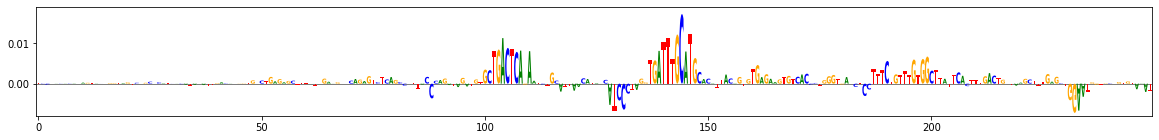

In [25]:
lm.Logo(contribution_scores_hg38, figsize = (20, 2))
plt.ylim((1.1*np.min(np.min(contribution_scores_hg38)), 1.1*np.max(np.max(contribution_scores_hg38))))
plt.savefig(f'./example_tracks/predictions_chrombpnet_HTRA4_enhancer_{sample}_hg38.pdf', bbox_inches = 'tight')

In [107]:
seq_hap1 = nucleotide_sequence[:60] + 'A' + nucleotide_sequence[61:]
seq_hap2 = nucleotide_sequence

In [108]:
contribution_scores_hap1 = extract_contribution_scores_for_region(sample, 'hap1', chrom, start, end)
contribution_matrix_hap1 = construct_matrix(seq_hap1, contribution_scores_hap1)

contribution_scores_hap2 = extract_contribution_scores_for_region(sample, 'hap2', chrom, start, end)
contribution_matrix_hap2 = construct_matrix(seq_hap2, contribution_scores_hap2)

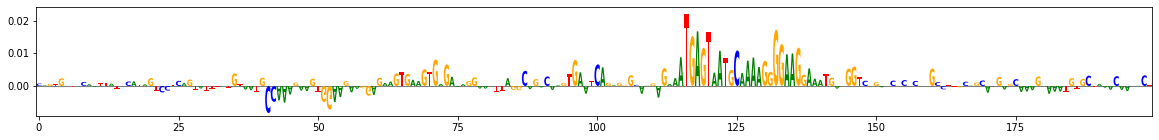

In [109]:
lm.Logo(contribution_matrix_hap1, figsize = (20, 2))
plt.ylim((1.1*np.min(np.min(pd.concat([contribution_matrix_hap1, contribution_matrix_hap2]))), 
          1.1*np.max(np.max(pd.concat([contribution_matrix_hap1, contribution_matrix_hap2])))))
plt.savefig(f'./example_tracks/balanced_region_SDCCAG8_enhancer_{sample}_hap1.pdf', bbox_inches = 'tight')

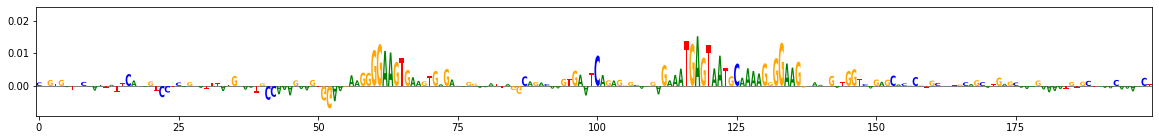

In [110]:
lm.Logo(contribution_matrix_hap2, figsize = (20, 2))
plt.ylim((1.1*np.min(np.min(pd.concat([contribution_matrix_hap1, contribution_matrix_hap2]))), 
          1.1*np.max(np.max(pd.concat([contribution_matrix_hap1, contribution_matrix_hap2])))))
plt.savefig(f'./example_tracks/balanced_region_SDCCAG8_enhancer_{sample}_hap2.pdf', bbox_inches = 'tight')